In [1]:
#!pip install yfinance
#import yfinance as yf
#!pip install mplfinance
#!pip install pytorch-
#!pip install pandas_ta
#! pip install statsforecast s3fs datasetsforecast
#!pip install git+https://github.com/Nixtla/neuralforecast.git@main

In [ ]:
import io
import os
import requests
import pandas as pd
import pandas_ta as ta
import numpy as np
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator
#import mplfinance as mpf
from statsforecast import StatsForecast

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from ray import tune

from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

from google.colab import drive, files

/usr/local/lib/python3.10/dist-packages/statsforecast/core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Basic portfolio management strategy

Each day, compute the overall market tendency and individual signals for each company:
- BUY the 5 highest returns
- SELL the 5 lowest returns

The 10 medium returns will be assigned a HOLD signal.

In [ ]:
files.upload()

In [ ]:
p2p20 = pd.read_csv('./p2p20.csv')

In [ ]:
# Calculate Company-Level Returns by computing the percentage change in the closing prices from one day to the next
p2p20['return'] = p2p20.groupby('company')['close'].pct_change()
# for the first day of the dataset, the return can't be computed since it misses the data from the previous day. fill with 0
p2p20['return'] = p2p20['return'].fillna(0)

# Calculate the market tendency by taking the mean of the returns of all companies for each day.
for date in p2p20['date'].unique():
    # Calculate the mean return for the current date
    mean_return = p2p20.loc[p2p20['date'] == date, 'return'].mean()
    # Fill the 'market_tendency' value for the current date with the mean return
    p2p20.loc[p2p20['date'] == date, 'market_tendency'] = mean_return

# Display the updated dataframe
p2p20.head()

,company,date,open,high,low,close,adj close,volume,return,market_tendency
0,UBER,2021-08-16,41.759998,41.790001,40.860001,41.500000,41.500000,19223500.0,0.000000,0.000000
1,UBER,2021-08-17,41.000000,41.480000,40.580002,41.000000,41.000000,20364400.0,-0.012048,-0.004468
2,UBER,2021-08-18,40.970001,41.529999,40.799999,40.880001,40.880001,13682300.0,-0.002927,0.030877
3,UBER,2021-08-19,40.279999,40.599998,39.509998,39.860001,39.860001,22471400.0,-0.024951,-0.009557
4,UBER,2021-08-20,39.689999,40.080002,39.240002,39.950001,39.950001,18080700.0,0.002258,0.018186


In [ ]:
# what is the return of each company on a specific day?
returns_on_specific_date = p2p20[p2p20['date'] == '2021-08-17']

# Display the returns for each company on the specific date
print(returns_on_specific_date[['company', 'return']])

      company    return
1        UBER -0.012048
681      ABNB -0.031433
1361     LYFT -0.033838
2041     EXPE -0.010892
2721     TASK  0.117215
3401     TRIP -0.013413
4081     YELP -0.030686
4761     FVRR -0.015414
5441     DASH -0.009538
6121     UPWK -0.026430
6801     YNDX -0.006330
7481       ZM -0.008237
8161     DOCU -0.004080
8841     TEAM  0.008113
9521      DBX -0.012137
10201     FIL -0.052007
10907      AR  0.121974
12244     GRT  0.016480
12950   THETA -0.082183


In [ ]:
# select the 5 lowest and the 5 highest return on a specific date
sorted_returns = returns_on_specific_date.sort_values(by='return')

# Select the 5 lowest returns
lowest_returns = sorted_returns.head(5)

# Select the 5 highest returns
highest_returns = sorted_returns.tail(5)

# Select the 10 medium returns
medium_returns = sorted_returns.iloc[5:-5]

# Display the selected returns for each company on the specific date
print("5 Lowest Returns:")
print(lowest_returns[['company', 'return']])
print("10 Medium Returns:")
print(medium_returns[['company', 'return']])
print("\n5 Highest Returns:")
print(highest_returns[['company', 'return']])

5 Lowest Returns:
      company    return
12950   THETA -0.082183
10201     FIL -0.052007
1361     LYFT -0.033838
681      ABNB -0.031433
4081     YELP -0.030686
10 Medium Returns:
     company    return
6121    UPWK -0.026430
4761    FVRR -0.015414
3401    TRIP -0.013413
9521     DBX -0.012137
1       UBER -0.012048
2041    EXPE -0.010892
5441    DASH -0.009538
7481      ZM -0.008237
6801    YNDX -0.006330

5 Highest Returns:
      company    return
8161     DOCU -0.004080
8841     TEAM  0.008113
12244     GRT  0.016480
2721     TASK  0.117215
10907      AR  0.121974


In [ ]:
# Concatenate the lowest, medium and highest returns dataframes
ranked_returns = pd.concat([lowest_returns, medium_returns, highest_returns])

# Define the number of companies to buy, sell and hold
num_to_buy = 5
num_to_sell = 5
num_to_hold = 10

# Sort the ranked returns dataframe by 'return'
ranked_returns_sorted = ranked_returns.sort_values(by='return')

# Assign 'sell', 'hold', 'buy' signals based on ranks
ranked_returns_sorted['signal'] = 'Hold'  # Default to 'Hold' for all companies
ranked_returns_sorted.loc[ranked_returns_sorted.index[:num_to_sell], 'signal'] = 'Sell'  # Set 'Sell' for the lowest returns
ranked_returns_sorted.loc[ranked_returns_sorted.index[-num_to_buy:], 'signal'] = 'Buy'  # Set 'Buy' for the highest returns

# Assign 'Hold' for the medium return companies
ranked_returns_sorted.iloc[num_to_sell:num_to_sell+num_to_hold, -1] = 'Hold'

# Display the ranked companies with their signals
print(ranked_returns_sorted[['company', 'return', 'signal']])

      company    return signal
12950   THETA -0.082183   Sell
10201     FIL -0.052007   Sell
1361     LYFT -0.033838   Sell
681      ABNB -0.031433   Sell
4081     YELP -0.030686   Sell
6121     UPWK -0.026430   Hold
4761     FVRR -0.015414   Hold
3401     TRIP -0.013413   Hold
9521      DBX -0.012137   Hold
1        UBER -0.012048   Hold
2041     EXPE -0.010892   Hold
5441     DASH -0.009538   Hold
7481       ZM -0.008237   Hold
6801     YNDX -0.006330   Hold
8161     DOCU -0.004080   Hold
8841     TEAM  0.008113    Buy
12244     GRT  0.016480    Buy
2721     TASK  0.117215    Buy
10907      AR  0.121974    Buy


In [ ]:
# compute a sell, hold, buy signal for each company every day
num_to_buy = 5
num_to_sell = 5
num_to_hold = 10

# Group the dataframe by date
grouped_by_date = p2p20.groupby('date')

# Iterate over each group (date)
for date, group in grouped_by_date:
    # Sort the group by 'return' column
    sorted_group = group.sort_values(by='return')

    # Identify the market tendency for the current date
    market_tendency = group['market_tendency'].iloc[0]

    # Assign 'sell', 'hold', 'buy' signals based on ranks
    sorted_group.loc[sorted_group.index[:num_to_sell], 'signal'] = 'Sell'
    sorted_group.iloc[num_to_sell:num_to_sell+num_to_hold, -1] = 'Hold'
    sorted_group.loc[sorted_group.index[-num_to_buy:], 'signal'] = 'Buy'

    # Assign 'Hold' for the medium return companies

    # Update the original dataframe with the computed signals for the current date
    p2p20.loc[group.index, 'signal'] = sorted_group['signal']

# Display the updated dataframe with the signals
p2p20.head()

,company,date,open,high,low,close,adj close,volume,return,market_tendency,signal
0,UBER,2021-08-16,41.759998,41.790001,40.860001,41.500000,41.500000,19223500.0,0.000000,0.000000,Sell
1,UBER,2021-08-17,41.000000,41.480000,40.580002,41.000000,41.000000,20364400.0,-0.012048,-0.004468,Hold
2,UBER,2021-08-18,40.970001,41.529999,40.799999,40.880001,40.880001,13682300.0,-0.002927,0.030877,Hold
3,UBER,2021-08-19,40.279999,40.599998,39.509998,39.860001,39.860001,22471400.0,-0.024951,-0.009557,Hold
4,UBER,2021-08-20,39.689999,40.080002,39.240002,39.950001,39.950001,18080700.0,0.002258,0.018186,Hold


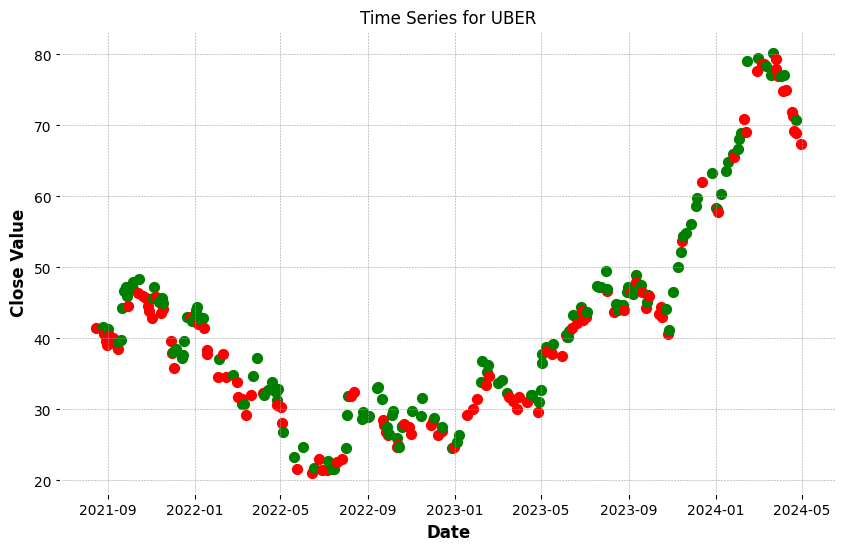

In [ ]:
# plotting buy and hold signals over time
company_name = 'UBER'

# Filter the dataframe for the specific company and where signal is not 'Hold'
company_df = p2p20[(p2p20['company'] == company_name) & (p2p20['signal'] != 'Hold')]

# Plotting the time series
plt.figure(figsize=(10, 6))

# Scatter plot for signal indicators
colors = {'Sell': 'red', 'Buy': 'green'}  # No 'Hold' values
for index, row in company_df.iterrows():
    plt.scatter(row['date'], row['close'], color=colors[row['signal']], s=50)

# Customize plot
plt.title(f'Time Series for {company_name}')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.grid(True)
plt.show()

In [ ]:
#save dataset
p2p20.to_csv('p2p20.csv', index=False)
files.download('p2p20.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### improve the portfolio management strategy:

The signal is calculated on daily returns, why not calculating it on a weekly or monthly base?

We could compare asset management strategies based on the total return of the portfolio while trading daily, weekly, or monthly with the 5/10/5 rule.


Optimize portfolio with:
- Value at Risk
- higher quantile level

# Correlation Analysis

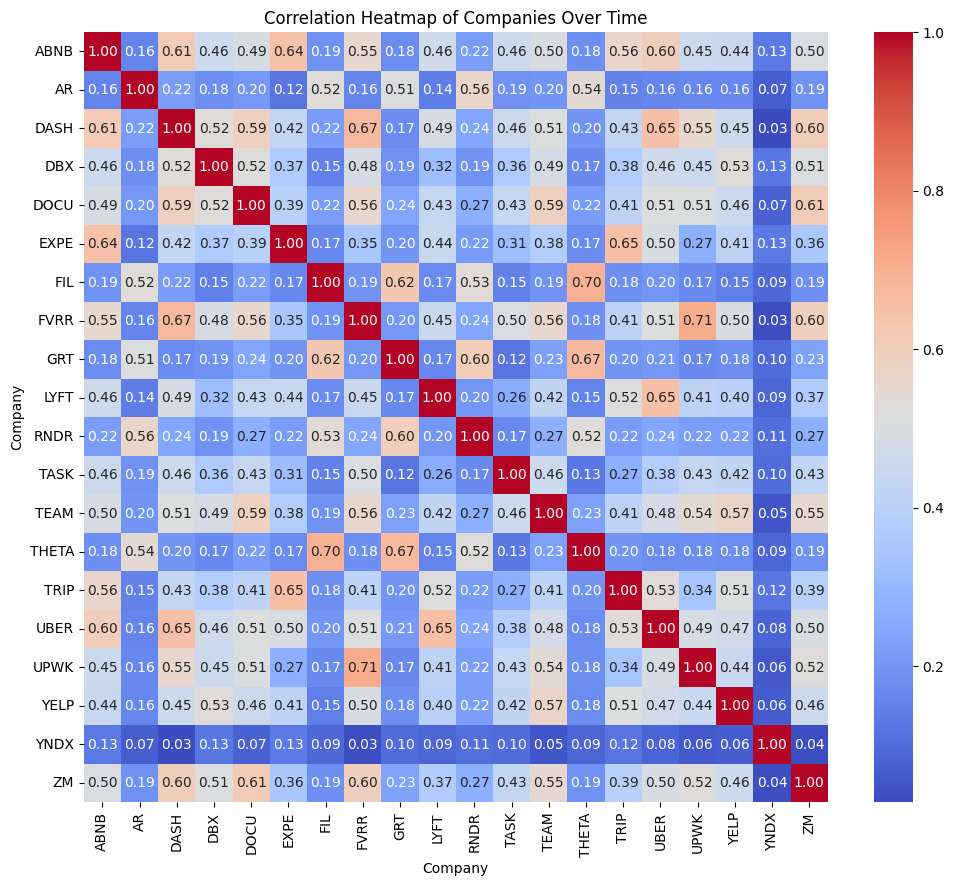

In [ ]:
# Pivot the dataframe so that each row represents a date and each column represents a company
p2p20_pivot = p2p20.pivot(index='date', columns='company', values='return')

# Calculate the daily returns for each company
returns = p2p20_pivot.pct_change()

# Calculate the correlation matrix based on the daily returns
correlation_matrix = returns.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Companies Over Time')
plt.xlabel('Company')
plt.ylabel('Company')
plt.show()

In [ ]:
# Filter the correlation matrix to find pairs with correlation score >= 0.65
high_correlation_pairs = correlation_matrix[correlation_matrix >= 0.65]

# Iterate over the correlation matrix to extract pairs of companies
correlation_pairs = []
added_pairs = set()  # Set to keep track of added pairs
for company1 in high_correlation_pairs.columns:
    for company2 in high_correlation_pairs.index:
        if company1 != company2 and not pd.isnull(high_correlation_pairs.loc[company2, company1]):
            # Sort the pair alphabetically to avoid duplicates (e.g., (A, B) and (B, A))
            pair = tuple(sorted([company1, company2]))
            # Add the pair to the list if it hasn't been added before
            if pair not in added_pairs:
                correlation_pairs.append((company1, company2, high_correlation_pairs.loc[company2, company1]))
                added_pairs.add(pair)

# Create a DataFrame from the list of pairs
high_correlation_df = pd.DataFrame(correlation_pairs, columns=['Company 1', 'Company 2', 'Correlation'])

# Display the list of pairs with correlation score >= 0.65
print("Pairs of companies with correlation score >= 0.65:")
print(high_correlation_df)

Pairs of companies with correlation score >= 0.65:
  Company 1 Company 2  Correlation
0      DASH      FVRR     0.672959
1      DASH      UBER     0.650414
2      EXPE      TRIP     0.652371
3       FIL     THETA     0.698108
4      FVRR      UPWK     0.710109
5       GRT     THETA     0.668381
6      LYFT      UBER     0.654174


This correlation is not so convincing, but it's only a pearson effect, which does not consider the structure of the data. It breaks the ranks and use a normal distribution which does not match with reality. Tt does not say much about the potential forecasting success.

- Try other methods to calculate a correlation score.
- Tru correlation on daily, weekly and monthly returns.
- Use PCA and random matrix theory.
